In [1]:
"""
All tastes stacked
Different lambdas for each taste but same tau
SINGLE NEURON
"""

'\nAll tastes stacked\nDifferent lambdas for each taste but same tau\nSINGLE NEURON\n'

In [2]:
# Import stuff
import os
import scipy
import scipy.stats as stats
import pymc3 as pm
import theano.tensor as tt
import theano

%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
figsize(11, 9)

os.chdir('/media/bigdata/firing_space_plot/ephys_data')
from ephys_data import ephys_data
import visualize

In [3]:
data_dir = '/media/bigdata/Abuzar_Data/AS18/AS18_4Tastes_200229_154608'
dat = \
    ephys_data(data_dir)
dat.firing_rate_params = dat.default_firing_params

dat.get_unit_descriptors()
dat.get_spikes()
dat.get_firing_rates()
print(np.array(dat.spikes).shape)

All tastes have equal dimensions,concatenating and normalizing
(4, 30, 31, 7000)


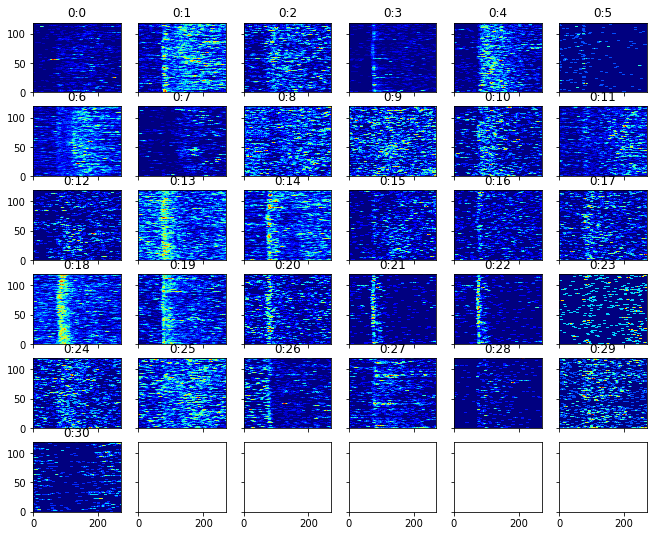

In [4]:
visualize.firing_overview(dat.all_normalized_firing);

In [5]:
nrn = np.arange(np.array(dat.spikes).shape[2])
taste_dat = np.array(dat.spikes)[:,:,nrn]
#taste_dat = np.array(dat.spikes)[:,:,nrn]
print(taste_dat.shape)

(4, 30, 31, 7000)


In [67]:
# Convert spikes to counts by binning
time_lims = [1500,4000]
bin_width = 25
t_vec = np.arange(taste_dat.shape[-1])
binned_t_vec = np.mean(t_vec[time_lims[0]:time_lims[1]].reshape((-1,bin_width)),axis=-1)
this_dat_binned = np.sum(taste_dat[...,time_lims[0]:time_lims[1]].reshape(*taste_dat.shape[:-1],-1,bin_width),axis=-1)
this_dat_binned = np.vectorize(np.int)(this_dat_binned)

print(this_dat_binned.shape)

(4, 30, 31, 100)


(4, 31, 100)


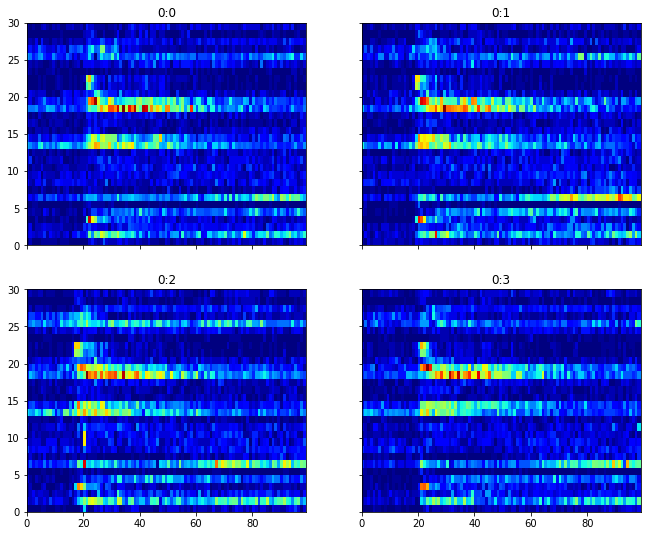

<Figure size 792x648 with 0 Axes>

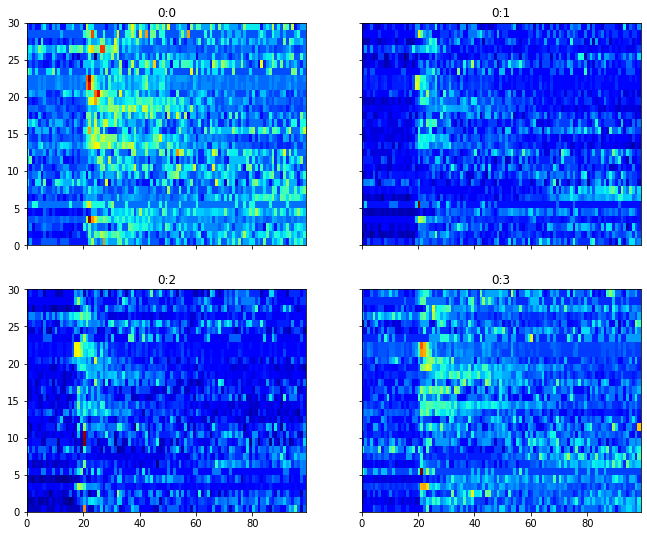

In [68]:
zscore_this_dat = np.array([stats.zscore(np.mean(nrn,axis=0),axis=None) \
                            for nrn in this_dat_binned.swapaxes(0,2)]).swapaxes(0,1)
mean_this_dat = np.mean(this_dat_binned,axis=1)
print(zscore_this_dat.shape)
visualize.firing_overview(mean_this_dat);
plt.figure();
visualize.firing_overview(zscore_this_dat);

(120, 31, 100)


<Figure size 792x648 with 0 Axes>

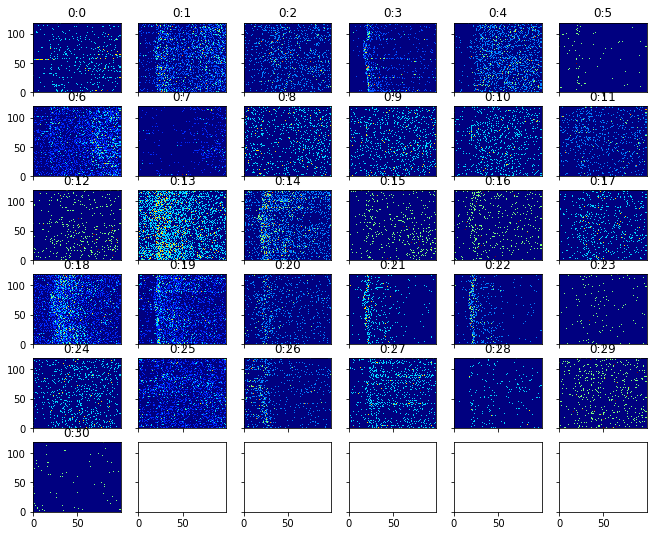

<Figure size 792x648 with 0 Axes>

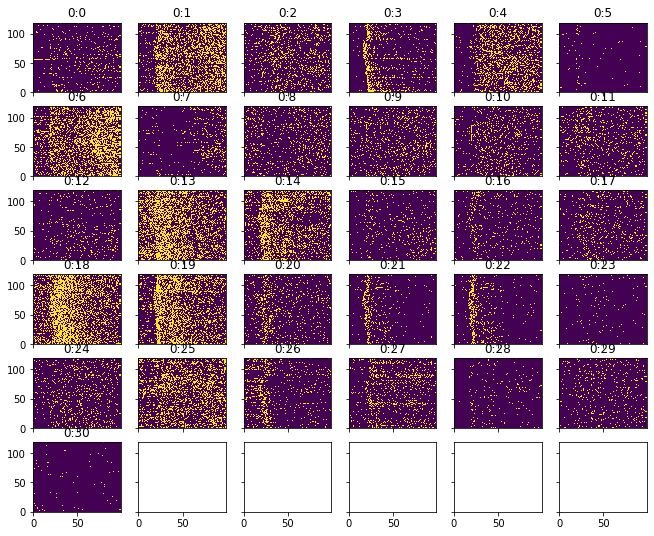

In [69]:
# Pick single trial
trial = np.arange(taste_dat.shape[1])
taste = np.arange(taste_dat.shape[0])

dat_binned_long = np.reshape(this_dat_binned,(-1,*this_dat_binned.shape[-2:]))
print(dat_binned_long.shape)
plt.figure();
visualize.firing_overview(dat_binned_long.swapaxes(0,1),cmap='jet');
dat_binned_long[dat_binned_long>1] = 1
plt.figure();
visualize.firing_overview(dat_binned_long.swapaxes(0,1),cmap='viridis');

In [71]:
states = 4
tastes = this_dat_binned.shape[0]
split_list = np.array_split(this_dat_binned,states,axis=-1)
# Cut all to the same size
min_val = min([x.shape[-1] for x in split_list])
split_array = np.array([x[...,:min_val] for x in split_list])
print(split_array.shape)
mean_vals = np.mean(split_array,axis=(2,-1)).swapaxes(0,1)
mean_vals += 0.01 # To avoid zero starting prob
print(mean_vals.shape) # Trials x nrns
# print(mean_vals)

(4, 4, 30, 31, 25)
(4, 4, 31)


In [72]:
idx = np.arange(this_dat_binned.shape[-1]) # Index
array_idx = np.broadcast_to(idx, dat_binned_long.shape)
idx_range = idx.max() - idx.min()
print(idx.min())
print(idx.max())
print(array_idx.shape)

0
99
(120, 31, 100)


In [73]:
even_switches = np.linspace(0,idx.max(),states+1)
even_switches_normal = even_switches/np.max(even_switches)
print(even_switches)
print(even_switches_normal[1:(states)])

[ 0.   24.75 49.5  74.25 99.  ]
[0.25 0.5  0.75]


(4, 4, 31)


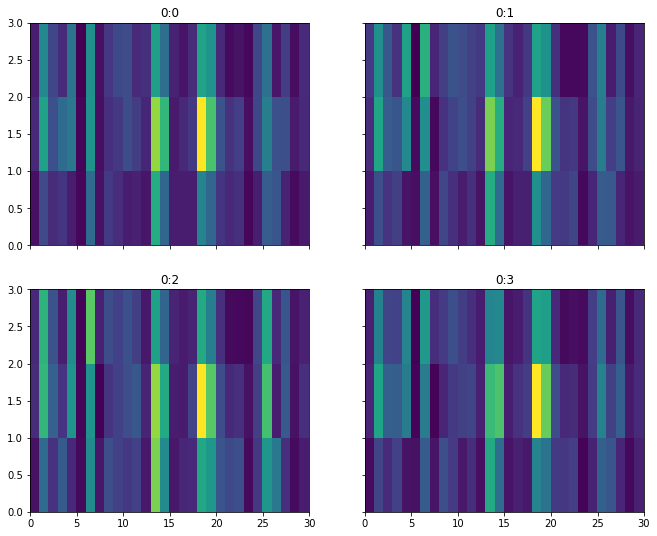

In [74]:
with pm.Model() as model:
    
    
    # SAME LAMBDAS ACROSS ALL TRIALS
    # Finite, but somewhere on the lower end, Beta prior
    # Shared hyperprior for single neuron (across tastes and states)
#     a_lambda = 2
#     b_lambda = 5
    a_lambda = pm.HalfNormal('a_lambda',3, shape = (mean_vals.shape[-1]))
    b_lambda = pm.HalfNormal('b_lambda',3, shape = (mean_vals.shape[-1]))
    
    lambda_latent = pm.Beta('lambda', a_lambda, b_lambda, 
                            testval = mean_vals, 
                            shape = (mean_vals.shape))
    
print(lambda_latent.tag.test_value.shape)

visualize.firing_overview(lambda_latent.tag.test_value,cmap='viridis');

In [75]:
trial_num = array_idx.shape[0]

with model:
    
    # INDEPENDENT TAU FOR EVERY TRIAL
    a = pm.HalfNormal('a_tau', 3., shape = states - 1)
    b = pm.HalfNormal('b_tau', 3., shape = states - 1)
    
    # Stack produces states x trials --> That gets transposed to trials x states and gets sorted along states (axis=-1)
    # Sort should work the same way as the Ordered transform --> see rv_sort_test.ipynb

    tau_latent = pm.Beta('tau_latent', a, b, 
                           shape = (trial_num, states-1),
                        testval = tt.tile(even_switches_normal[1:(states)],(array_idx.shape[0],1))).sort(axis=-1)
       
    tau = pm.Deterministic('tau', idx.min() + (idx.max() - idx.min()) * tau_latent)

print(tau.tag.test_value.shape)
tau_test_value = tau.tag.test_value

(120, 3)


In [76]:
print(array_idx.shape)

(120, 31, 100)


In [77]:
print(tt.tile(array_idx,(3,1,1,1)).swapaxes(0,1).tag.test_value.shape)

(120, 3, 31, 100)


In [78]:
with model:
    
    # Assign lambdas to time_bin indices using sigmoids centered on switchpoints
    # Refer to https://www.desmos.com/calculator/yisbydv2cq
    
    weight_1_stack = tt.nnet.sigmoid(array_idx - tau[:,0][...,np.newaxis,np.newaxis])
    weight_2_stack = tt.nnet.sigmoid(array_idx - tau[:,1][...,np.newaxis,np.newaxis])
    weight_3_stack = tt.nnet.sigmoid(array_idx - tau[:,2][...,np.newaxis,np.newaxis])

#     tau = tau[...,np.newaxis,np.newaxis]
#     weight_stack = tt.nnet.sigmoid(tt.tile(array_idx,(states-1,1,1,1)).swapaxes(0,1) - tau)
    
print(weight_1_stack.tag.test_value.shape)
print(lambda_latent.tag.test_value.shape)

(120, 31, 100)
(4, 4, 31)


In [79]:
weight_1_test =  weight_1_stack.tag.test_value[0]
lambda_latent_test = lambda_latent.tag.test_value[0]
print(weight_1_test.shape)
print(lambda_latent_test.shape)

(31, 100)
(4, 31)


In [80]:
with model:
    
    taste_label = np.repeat([0,1,2,3],30)
    
#     # 3 states
#     lambda_ = np.multiply(1 - weight_1_stack, lambda_latent[taste_label,0][:,:,np.newaxis]) + \
#                 np.multiply(weight_1_stack * (1 - weight_2_stack), lambda_latent[taste_label][:,1][:,:,np.newaxis]) + \
#                 np.multiply(weight_2_stack, lambda_latent[taste_label,2][:,:,np.newaxis])
    
    # 4 states
    lambda_ = np.multiply(1 - weight_1_stack, lambda_latent[taste_label,0][:,:,np.newaxis]) + \
                np.multiply(weight_1_stack * (1 - weight_2_stack), lambda_latent[taste_label][:,1][:,:,np.newaxis]) + \
                np.multiply(weight_2_stack * (1 - weight_3_stack), lambda_latent[taste_label][:,2][:,:,np.newaxis]) + \
                np.multiply(weight_3_stack, lambda_latent[taste_label,3][:,:,np.newaxis])

#     lambda_latent_temp = lambda_latent[taste_label,:,:,np.newaxis]
#     print(lambda_latent.tag.test_value.shape)
#     print(lambda_latent_temp.tag.test_value.shape)
    
#     lambda_ = np.multiply(1 - weight_stack[:,0], lambda_latent_temp[:,0]) + \
#                 np.multiply(weight_stack[:,0] * (1 - weight_stack[:,1]), lambda_latent_temp[:,1]) + \
#                 np.multiply(weight_stack[:,1] * (1 - weight_stack[:,2]), lambda_latent_temp[:,2]) + \
#                 np.multiply(weight_stack[:,2], lambda_latent_temp[:,3])

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3]
(120, 31, 100)
(120, 31, 100)


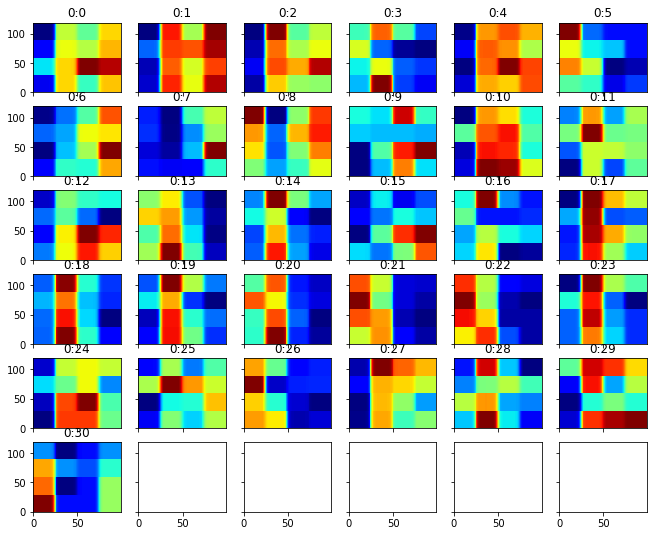

<Figure size 792x648 with 0 Axes>

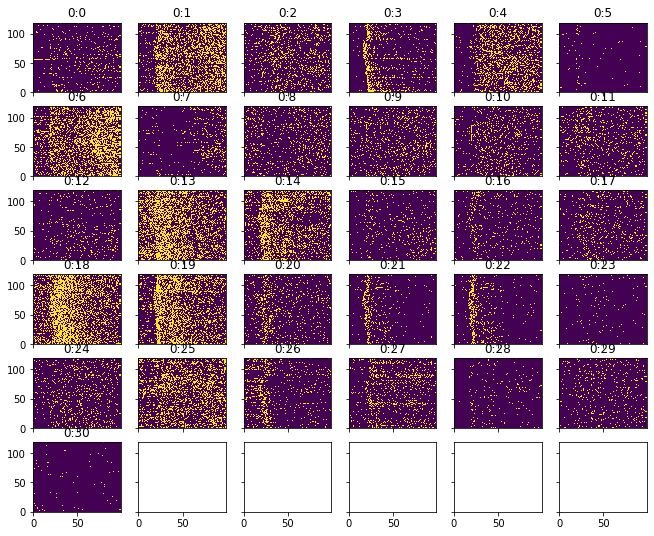

In [81]:
print(taste_label)
print(weight_1_stack.tag.test_value.shape)
print(lambda_.tag.test_value.shape)
visualize.firing_overview(lambda_.tag.test_value.swapaxes(0,1));
plt.figure()
visualize.firing_overview(dat_binned_long.swapaxes(0,1),cmap='viridis');

In [82]:
# Using Bernoullo likelihood for count data
with model:
    observation = pm.Bernoulli("obs", lambda_, observed=dat_binned_long)

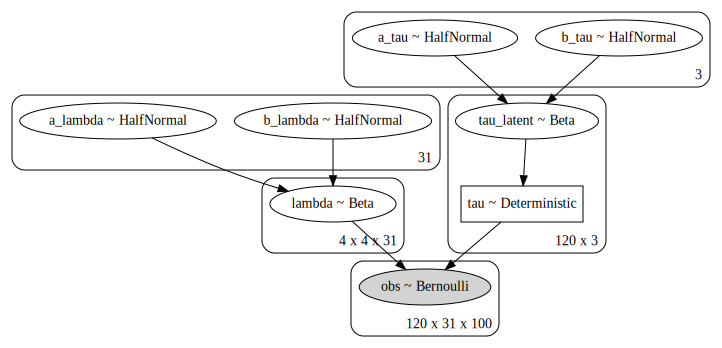

In [83]:
pm.model_to_graphviz(model)

In [84]:
with model:
    #step= pm.Metropolis()
    #step= pm.NUTS()
    #trace = pm.sample(100, tune=10,
    #                  step = step,
    #                  chains = 30, cores = 30)
    inference = pm.ADVI('full-rank')
    approx = pm.fit(n=15000, method=inference)
    trace = approx.sample(draws=10000)

  0%|          | 0/15000 [00:00<?, ?it/s]/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Average Loss = 1.2572e+05: 100%|██████████| 15000/15000 [09:23<00:00, 26.60it/s]
Finished [100%]: Average Loss = 1.2572e+05


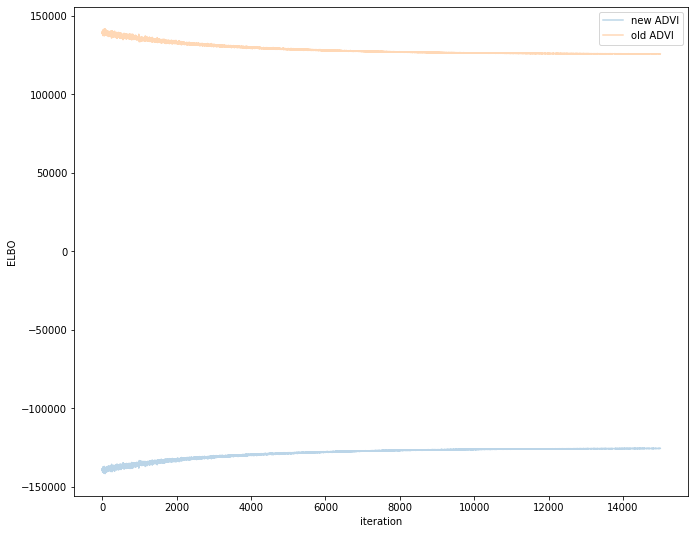

In [85]:
plt.plot(-inference.hist, label='new ADVI', alpha=.3)
plt.plot(approx.hist, label='old ADVI', alpha=.3)
plt.legend()
plt.ylabel('ELBO')
plt.xlabel('iteration');

In [86]:
print(trace['tau_latent'].shape)

(10000, 120, 3)


In [87]:
# pm.autocorrplot(trace['tau_latent'][:,0,0]);

In [88]:
# pm.autocorrplot(trace['tau_latent'][::20,0,0]);

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


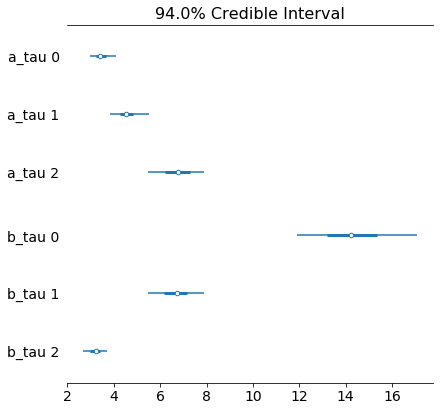

In [89]:
pm.forestplot(trace[::100], var_names = ['a_tau','b_tau']);
# pm.forestplot(trace, var_names = ['a_tau','b_tau']);

In [90]:
# pm.forestplot(trace[::100], var_names = 'tau');
# pm.forestplot(trace, var_names = 'tau');

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


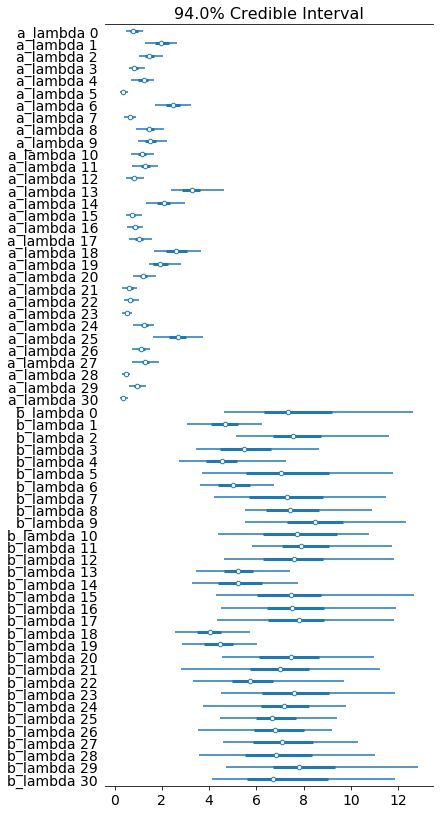

In [91]:
pm.forestplot(trace[::100], var_names = ['a_lambda','b_lambda']);
# pm.forestplot(trace, var_names = ['a_lambda','b_lambda']);

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


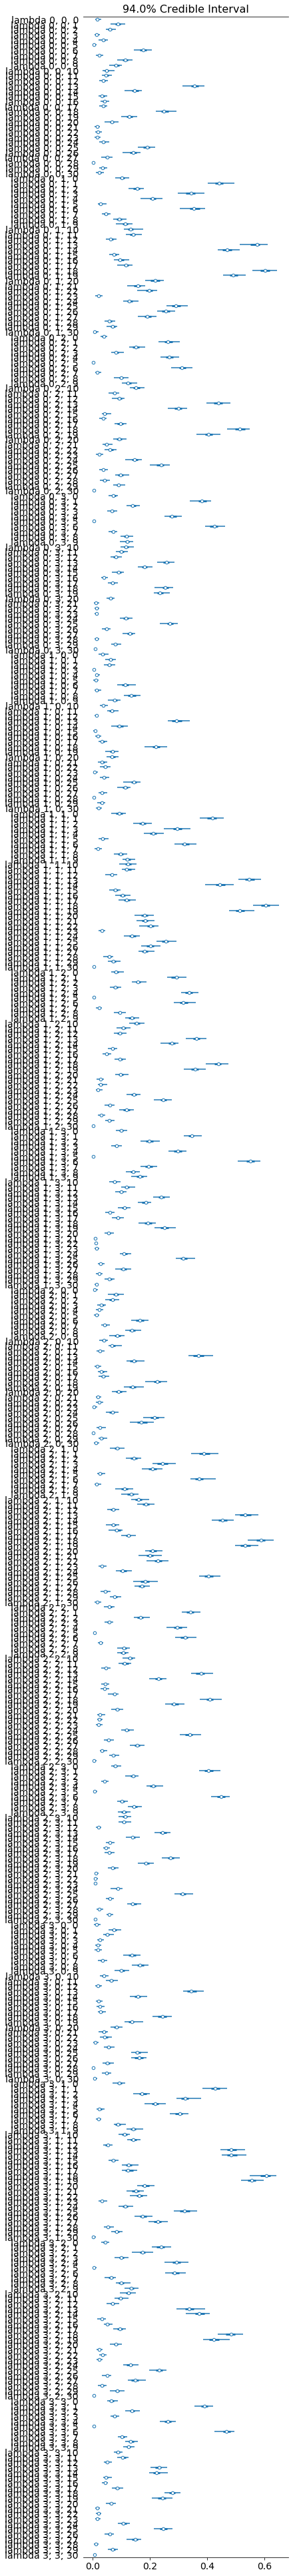

In [92]:
pm.forestplot(trace[::100], var_names = ['lambda']);
# pm.forestplot(trace, var_names = ['lambda']);

In [93]:
lambda_stack = trace['lambda'].swapaxes(0,1)
tau_samples = trace['tau']
print(tau_samples.shape)
print(lambda_stack.shape)

(10000, 120, 3)
(4, 10000, 4, 31)


In [94]:
mean_tau = np.mean(tau_samples, axis=0)
mean_lambda = np.mean(lambda_stack,axis=1).swapaxes(1,2)
print(mean_tau.shape)
print(mean_lambda.shape)

(120, 3)
(4, 31, 4)


(4, 31, 4)
(4, 31, 4)


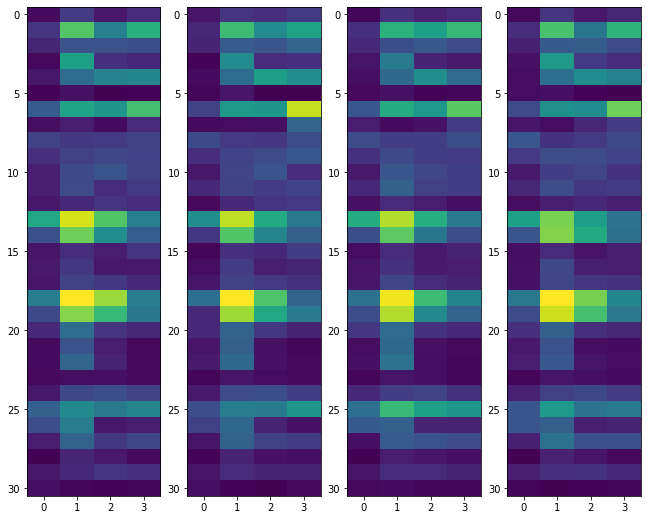

<Figure size 792x648 with 0 Axes>

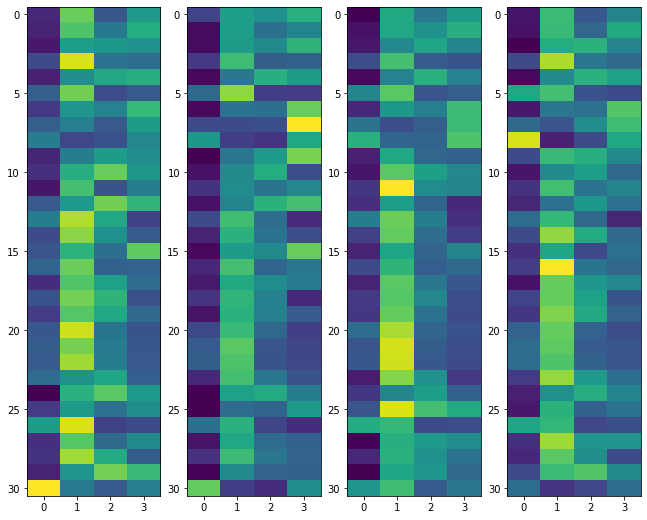

In [95]:
fig,ax = plt.subplots(1,mean_lambda.shape[0]);
for this_ax, this_dat in zip(ax, mean_lambda):
    this_ax.imshow(this_dat, interpolation = 'nearest', aspect = 'auto', cmap = 'viridis',
                                      vmin = 0, vmax = np.max(mean_lambda,axis=None))

plt.figure();
zscore_mean_lambda = np.array([stats.zscore(nrn,axis=None) for nrn in mean_lambda.swapaxes(0,1)]).swapaxes(0,1)
print(mean_lambda.shape)
print(zscore_mean_lambda.shape)
fig,ax = plt.subplots(1,mean_lambda.shape[0]);
for this_ax, this_dat in zip(ax, zscore_mean_lambda):
    this_ax.imshow(this_dat, interpolation = 'nearest', aspect = 'auto', cmap = 'viridis')



In [96]:
ppc = pm.sample_posterior_predictive(trace, samples = 2000, model = model)
ppc['obs'].shape

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
  0%|          | 0/2000 [00:00<?, ?it/s]/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
100%|██████████| 2000/2000 [01:10<00:00, 28.36it/s]


(2000, 120, 31, 100)

In [97]:
mean_ppc = np.mean(ppc['obs'],axis=0)
std_ppc = np.std(ppc['obs'],axis=0)
print(mean_ppc.shape)

(120, 31, 100)


In [98]:
mean_mean_tau = np.mean(tau_samples,axis=(0,1))
mean_mean_ppc = np.mean(mean_ppc,axis=1)
zscore_mean_mean_ppc = np.array([stats.zscore(nrn,axis=None) for nrn in mean_mean_ppc.swapaxes(0,1)]).swapaxes(0,1)
print(mean_mean_tau.shape)
print(mean_mean_ppc.shape)
print(zscore_mean_mean_ppc.shape)

(3,)
(120, 100)
(120, 100)


(1200000, 3)


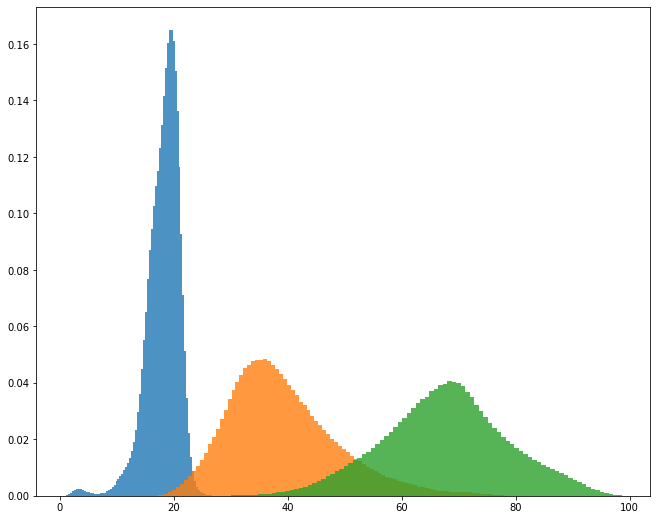

In [99]:
long_tau_samples = tau_samples.reshape((-1, tau_samples.shape[-1]))
print(long_tau_samples.shape)
for switch in range(long_tau_samples.shape[-1]):
     plt.hist(long_tau_samples[...,switch],bins = 100, density = True,alpha = 0.8)
    
# for this_ax in ax[-1,:]:
#     this_ax.set_xticks(np.arange(0,len(binned_t_vec),tick_interval));
#     this_ax.set_xticklabels(binned_t_vec[::tick_interval],rotation='vertical');

In [100]:
zscore_mean_ppc = stats.zscore(mean_ppc, axis=(0,1))
print(zscore_mean_ppc.shape)

(120, 31, 100)


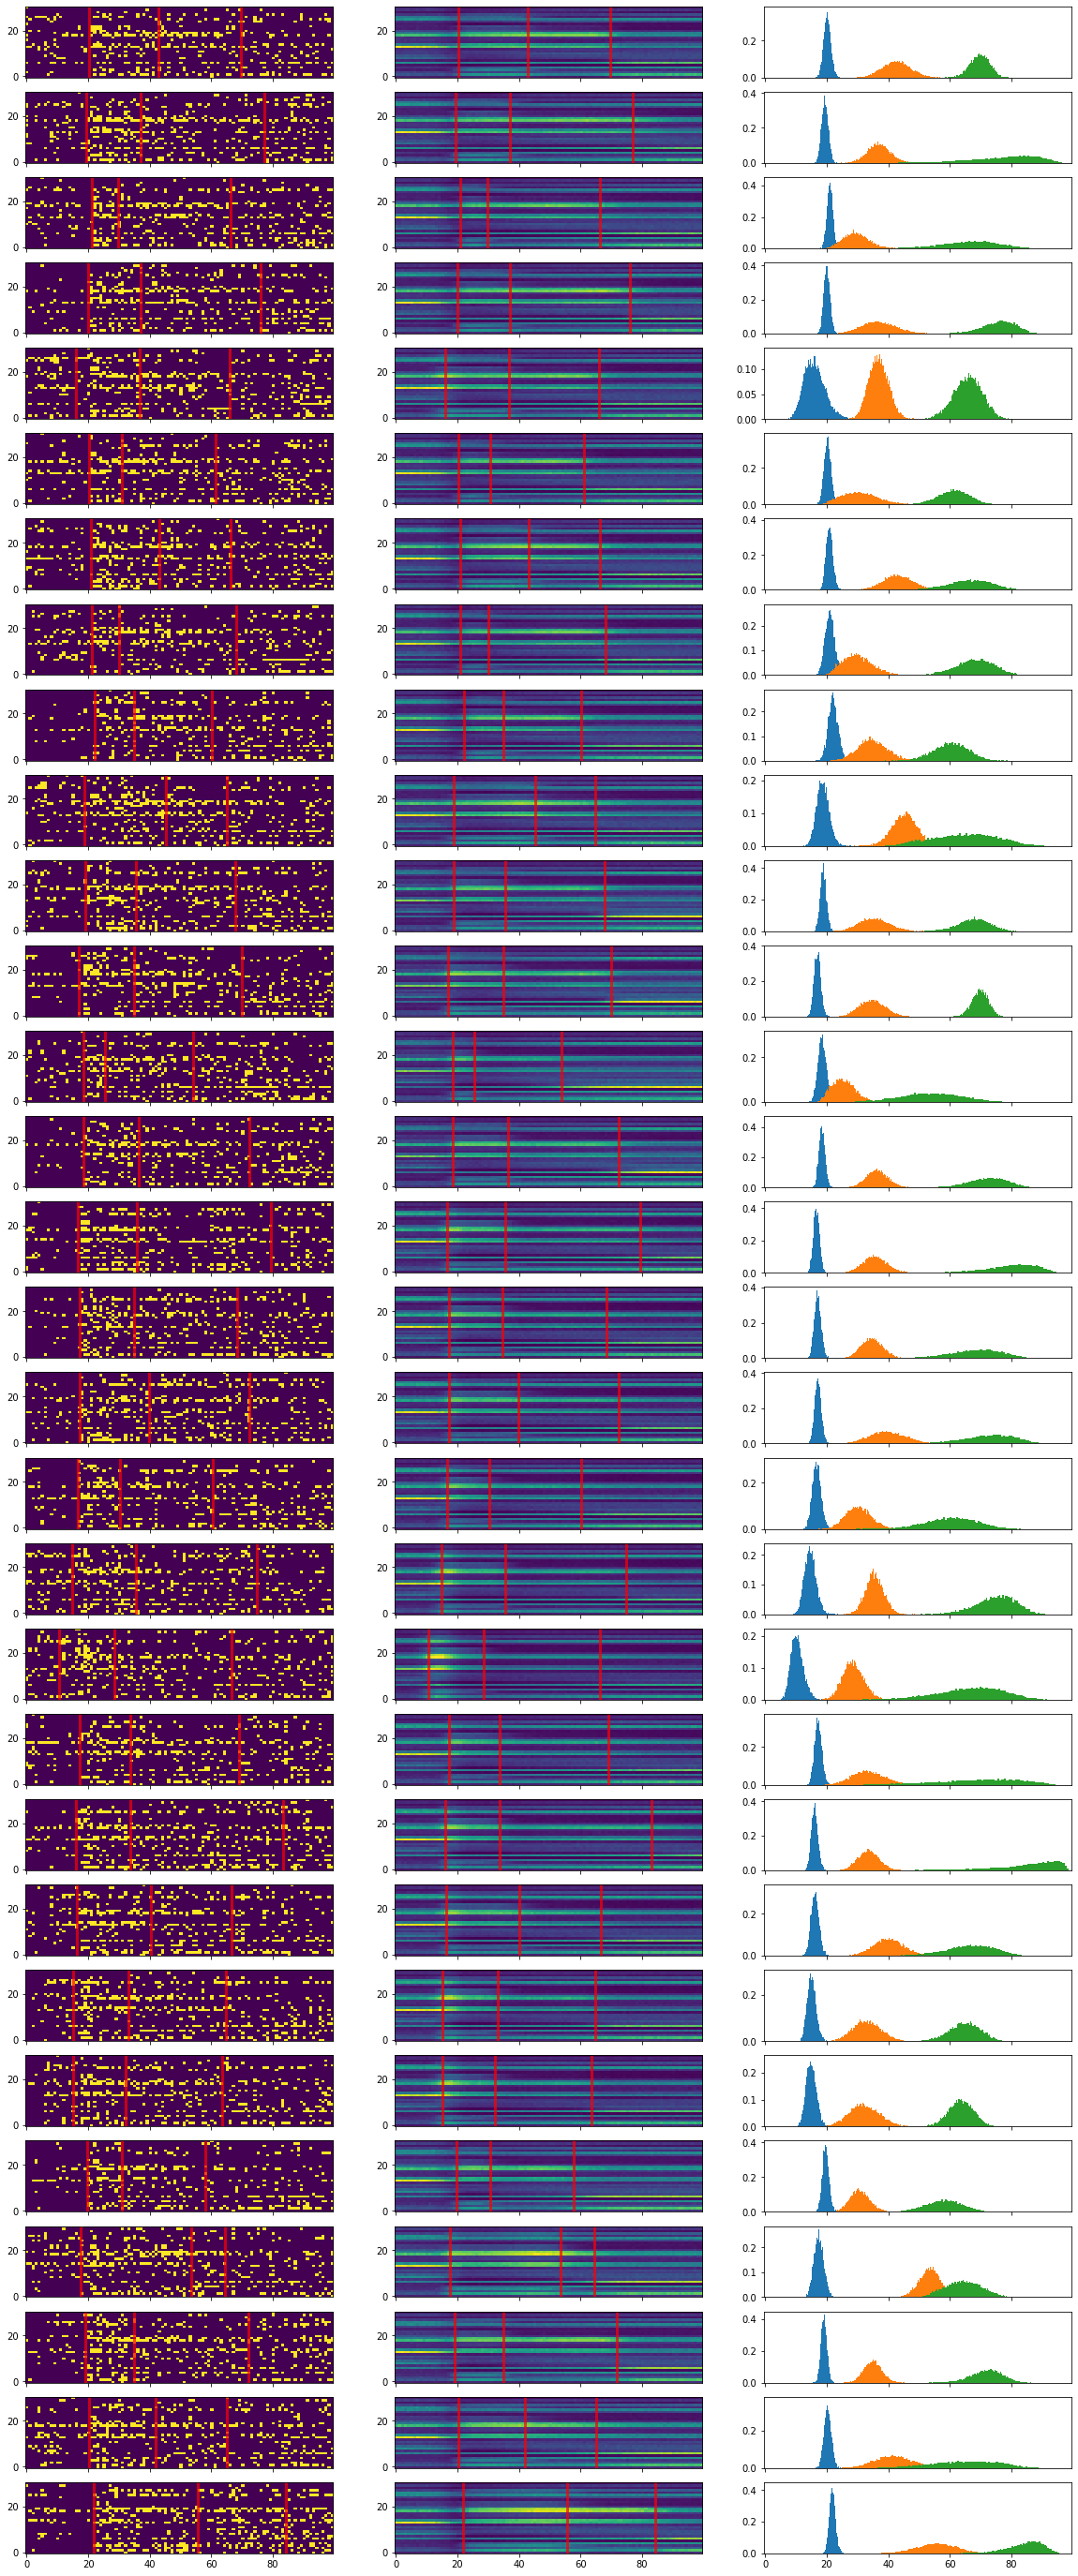

In [101]:
# Overlay raster with CDF of switchpoints
trial_count = 30
raw_trial_inds = np.random.choice(np.arange(mean_ppc.shape[0]),trial_count, replace = False)
raw_taste_labels = taste_label[raw_trial_inds]
taste_label_sort = np.argsort(raw_taste_labels)
trial_inds = raw_trial_inds[taste_label_sort]

fig, ax = plt.subplots(trial_count,3,sharex=True, figsize = (20,50))
for num,trial in enumerate(trial_inds):
    ax[num,0].imshow(dat_binned_long[trial],aspect='auto',origin='lower')
    ax[num,1].imshow(zscore_mean_ppc[trial], aspect='auto',origin='lower')
    ax[num,1].vlines(mean_tau[trial],-0.5,zscore_mean_ppc.shape[1]-0.5,color = 'red',linewidth = 3, alpha = 0.7)

    for state in range(tau_samples.shape[-1]):
        ax[num,2].hist(tau_samples[:,trial,state], bins = 100, density = True)
    ax[num,0].vlines(mean_tau[trial],-0.5,zscore_mean_ppc.shape[1]-0.5,color = 'red',linewidth = 3, alpha = 0.7)

# for col in range(2):
#     plt.sca(ax[-1,col])
#     plt.xticks(np.arange(0,len(binned_t_vec),tick_interval),binned_t_vec[::tick_interval],rotation='vertical');
#     plt.xlim(0,len(binned_t_vec))


In [108]:
# For visualization
# Take firing around each transition and stack it together to make a PSTH (not mean firing)
# Before and after alignment
window_radius_time = 300 # ms
window_radius_bins = window_radius_time//bin_width
print(window_radius_bins)

# Convert tau to interegers
int_mean_tau = np.vectorize(np.int)(mean_tau)

print(dat_binned_long.shape)
print(int_mean_tau.shape)

12
(120, 31, 100)
(120, 3)


In [109]:
# Take entire radius if available or whatever there is otherwise
# Iterate over changepoints and trials
# trials x neuron x switches x window_diameter
aligned_spikes = np.ones((*dat_binned_long.shape[:2],mean_tau.shape[-1],window_radius_bins*2))*-1
print(aligned_spikes.shape)

(120, 31, 3, 24)


In [110]:
for trial in range(dat_binned_long.shape[0]):
    for switch in range(mean_tau.shape[-1]):
        
        # Check whether we can pick out a window
        lower_bound = (int_mean_tau[trial,switch] - window_radius_bins)
        fin_lower_bound = lower_bound * (lower_bound > 0)
        upper_bound = (int_mean_tau[trial,switch] + window_radius_bins)
        fin_upper_bound = upper_bound * (upper_bound < dat_binned_long.shape[-1]) + \
                                            dat_binned_long.shape[-1] * (upper_bound > dat_binned_long.shape[-1])

        # Done this way so all windows can be accomodated whether they are of the expected size or not
        lower_window = dat_binned_long[trial,:,fin_lower_bound:int_mean_tau[trial,switch]]
        upper_window = dat_binned_long[trial,:,int_mean_tau[trial,switch]:fin_upper_bound]
        #If window is smaller than the expected size, put it in centered on transition
        aligned_spikes[trial,:,switch,(window_radius_bins - lower_window.shape[-1]):window_radius_bins] = lower_window
        aligned_spikes[trial,:,switch,window_radius_bins:(window_radius_bins + upper_window.shape[-1])] = upper_window

In [111]:
# break down aligned_spikes by taste
aligned_list = []
for taste in sorted(set(taste_label)):
    aligned_list.append(aligned_spikes[taste_label==taste])
taste_aligned_spikes = np.array(aligned_list)
print(taste_aligned_spikes.shape)

(4, 30, 31, 3, 24)


(31, 3, 120, 24)


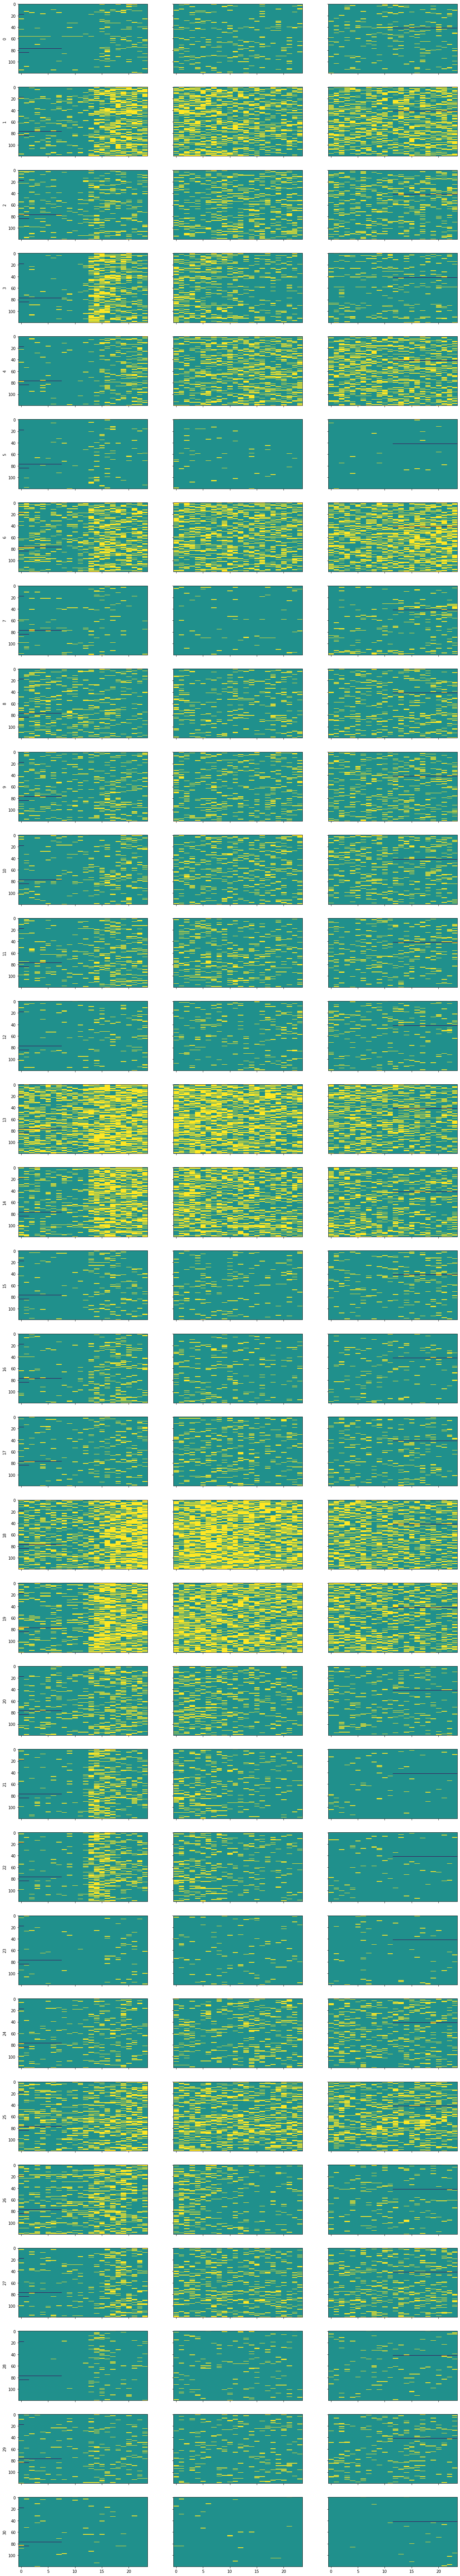

In [112]:
plot_dat = np.moveaxis(aligned_spikes,0,2)
print(plot_dat.shape)
fig, ax = plt.subplots(plot_dat.shape[0],plot_dat.shape[1],
                      sharex=True, sharey=True, figsize=(20,120))
iters = np.ndindex(ax.shape)
for this_iter,this_ax in zip(iters,ax.flatten()):
    #spikes = np.where(plot_dat[this_iter])
    #this_ax.scatter(spikes[1],spikes[0],s=2,alpha=0.7,marker = "|")
    this_ax.imshow(plot_dat[this_iter],aspect='auto',vmin=-1,vmax=1)
    
for num,this_ax in enumerate(ax[:,0].flatten()):
    this_ax.set_ylabel(num)

(31, 3, 4, 24)


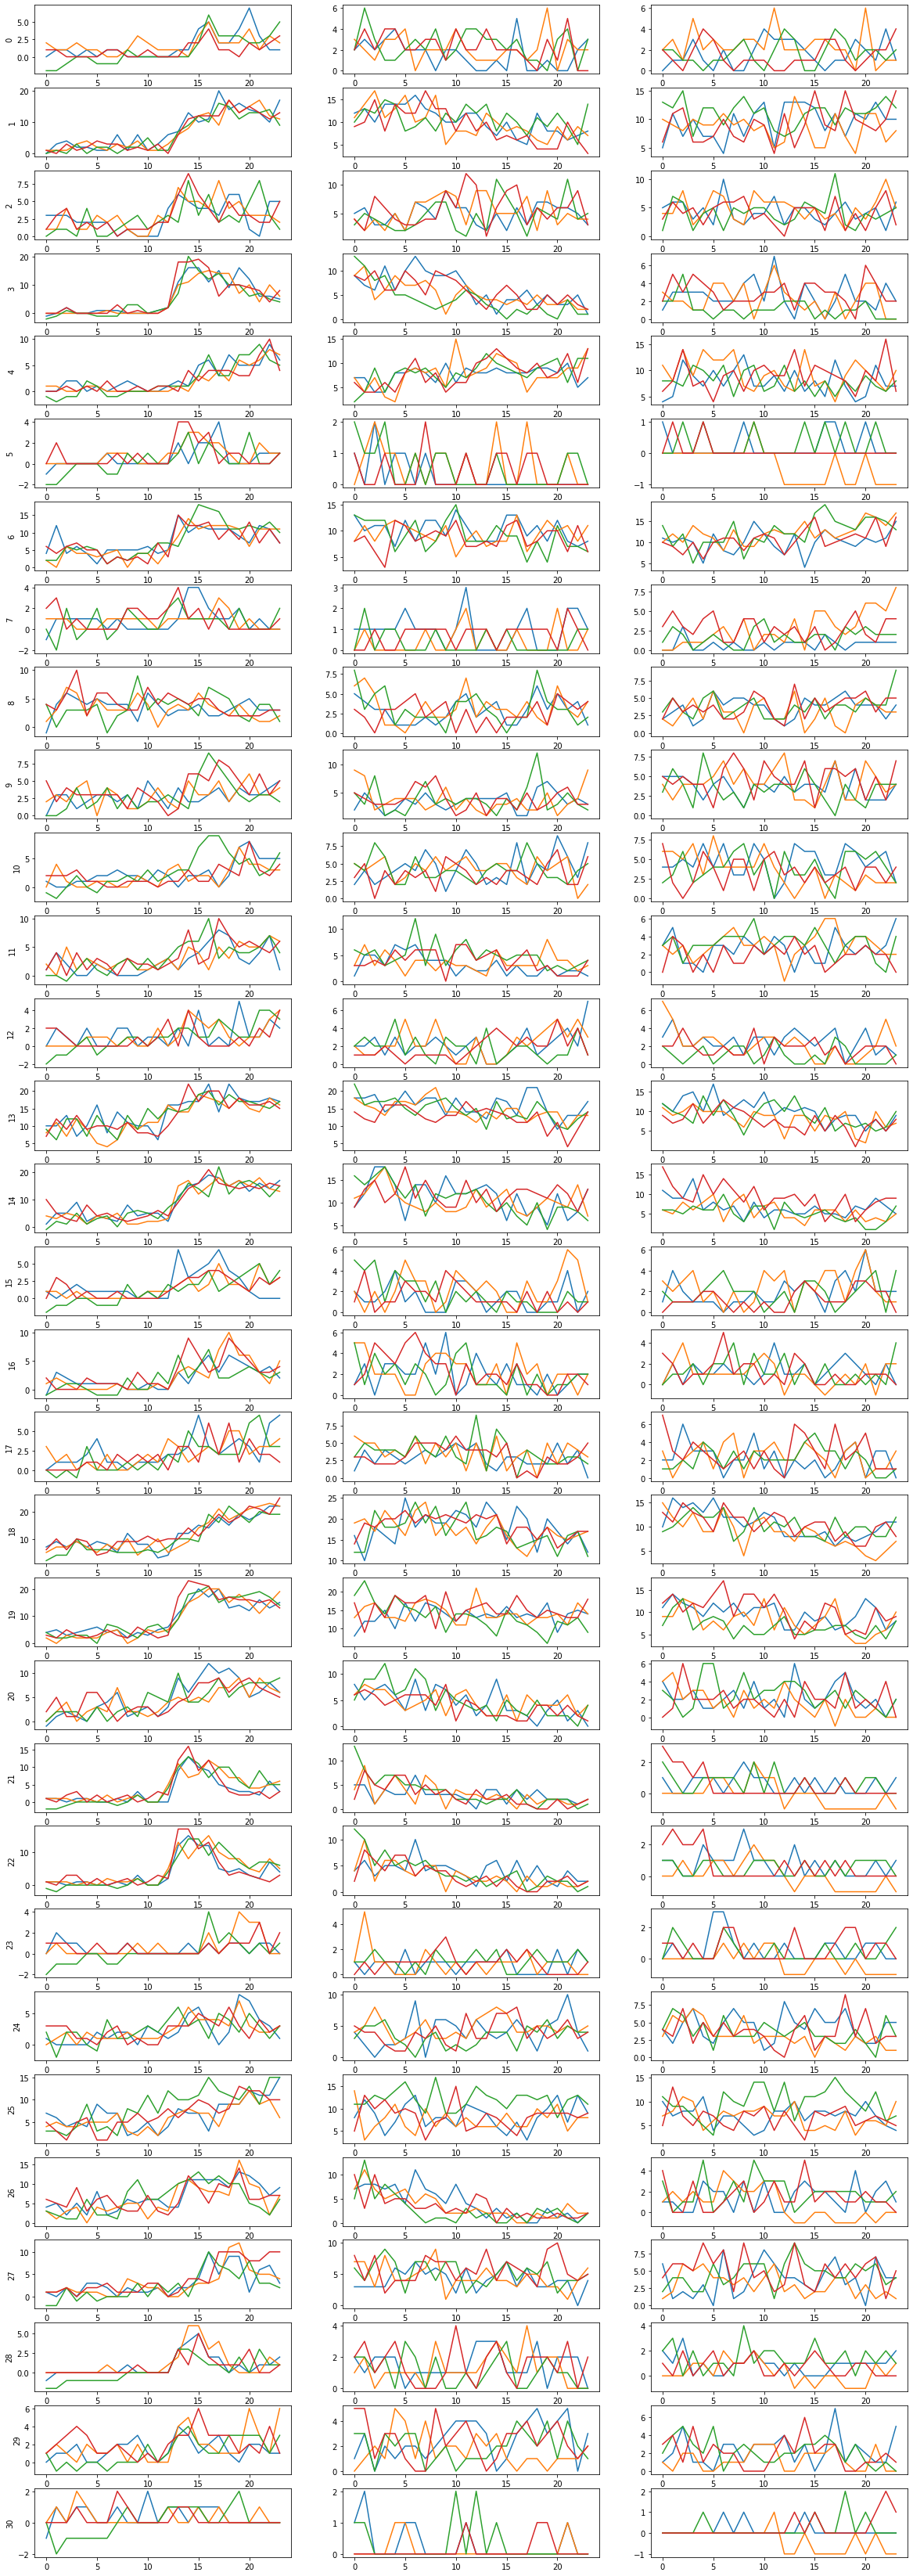

In [113]:
sum_aligned_spikes = np.moveaxis(np.sum(taste_aligned_spikes,axis=1),0,2)
print(sum_aligned_spikes.shape)
fig, ax = plt.subplots(sum_aligned_spikes.shape[0],sum_aligned_spikes.shape[1],
                      figsize = (20,60))
iters = np.ndindex(ax.shape)
for this_iter,this_ax in zip(iters,ax.flatten()):
    this_ax.plot(sum_aligned_spikes[this_iter].T)
for num,this_ax in enumerate(ax[:,0].flatten()):
    this_ax.set_ylabel(num)